Análisis del rendimiento de toda la comunidad que hacen dropshipping con SeventyBlock en el mes de octubre:
Para este análisis se desea determinar lo siguiente:

1. todas las comisiones logísticas sean pagadas, e imprimir en un excel todas las ordenes que no hayan sido pagadas por comision
2. todas las comisiones por referidos sean pagadas, e imprimir en un excel todas las ordenes que no hayan sido pagadas por comision
3. todas las comisiones por el plan de suscripción por producto sobre los proveedores hayan sido pagadas, e imprimir en un excel todas las ordenes que no hayan sido pagadas por comisión
4. top dropshippers con mas ventas en el mes
5. rendimiento de las transportadoras por los estados entregados
6. top ciudades con mayor cantidad de pedidos (excluyendo todo lo relacionado con seventy block)
7. top productos mas solicitados
8. recuento de estatus
9. historia en el tiempo de cantidad de pedidos generados dia por dia


In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
import warnings
import locale
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(font_scale=2)

ruta1 = './admin orden por fila oct 2023.xlsx'
ruta2 = './admin historial cartera Oct 2023.xlsx'
ruta3 = './proveedor historial de cartera oct 2023.xlsx'
ruta4 = './admin orden por product oct 2023.xlsx'

adminOrigen = pd.read_excel(ruta1)          # Datos adquiridos de todos los registros del mes de noviembre 2023
adminOrigen_prod = pd.read_excel(ruta4)     # Datos adquiridos del historial de cartera de la tienda nov 2023
adminHistorialCart = pd.read_excel(ruta2)   # Datos adquiridos de todos los registros del mes de noviembre 2023
proveHistorialCart = pd.read_excel(ruta3)  # Datos adquiridos del historial de cartera de la tienda nov 2023

Index(['FECHA DE REPORTE', 'ID', 'NÚMERO GUIA', 'HORA', 'FECHA',
       'DROPSHIPPER ID', 'DROPSHIPPER', 'REFERIDO PADRE ID',
       'REFERIDO PADRE EMAIL', 'CELULAR', 'EMAIL', 'TELEFONO TIENDA',
       'NOMBRE TIENDA', 'PROVEEDOR ID', 'PROVEEDOR EMAIL', 'PROVEEDOR NOMBRE',
       'PROVEEDOR VERIFICADO', 'TELÉFONO PROVEEDOR',
       'TELÉFONO TIENDA PROVEEDOR', 'ID DE BODEGA', 'BODEGA', 'NOMBRE CLIENTE',
       'TELÉFONO', 'EMAIL.1', 'TIPO DE IDENTIFICACION',
       'NRO DE IDENTIFICACION', 'ESTATUS', 'TIPO DE ENVIO',
       'DEPARTAMENTO DESTINO', 'CIUDAD DESTINO', 'DIRECCION', 'NOTAS',
       'TRANSPORTADORA', 'TOTAL DE LA ORDEN', 'PRECIO FLETE',
       'COSTO DEVOLUCION FLETE', 'COMISION DE LA PLATAFORMA',
       'TOTAL FULFILLMENT', 'TOTAL PRECIOS VISIBLES AL DROPSHIPPER',
       'GANANCIA SI ES ENTREGADO', 'GANANCIA TOTAL DE DROPSHIPPER',
       'GANANCIA TOTAL DE PROVEEDORES', 'CONTADOR NOVEDADES', 'NOVEDAD',
       'FUE SOLUCIONADA LA NOVEDAD', 'HORA DE NOVEDAD', 'FECHA DE NOVED

In [62]:
# se realiza de una vez la limpieza de datos:
# admin origen:

adminOrigenLimpio = adminOrigen[['ID', 'NÚMERO GUIA', 'HORA', 'FECHA',
        'DROPSHIPPER ID', 'DROPSHIPPER', 'REFERIDO PADRE ID',
        'REFERIDO PADRE EMAIL', 'CELULAR', 'TELEFONO TIENDA',
        'PROVEEDOR ID', 'PROVEEDOR NOMBRE','NOMBRE CLIENTE',
        'TELÉFONO', 'ESTATUS', 'TIPO DE ENVIO','DEPARTAMENTO DESTINO', 'CIUDAD DESTINO','TRANSPORTADORA', 
        'TOTAL DE LA ORDEN', 'PRECIO FLETE',
        'TOTAL PRECIOS VISIBLES AL DROPSHIPPER',
        'GANANCIA TOTAL DE DROPSHIPPER', 'TIPO DE USUARIO', 'PRODUCTOS',
        ]]

adminOrigenLimpio['FECHA'] = pd.to_datetime(adminOrigenLimpio['FECHA'])
adminOrigenLimpio = adminOrigenLimpio[adminOrigenLimpio['FECHA'].dt.month == 10]

# admin historial cartera:

adminHistorialCart['DESCRIPCIÓN'] = adminHistorialCart['DESCRIPCIÓN'].apply(lambda x: 'RECARGA CARTERA' if 'RECARGA DE SALDO EN CARTERA' in x else x)
adminHistorialCart['DESCRIPCIÓN'] = adminHistorialCart['DESCRIPCIÓN'].apply(lambda x: 'RET. ADMIN' if 'RET. ADMIN' in x else x)
adminHistorialCart['DESCRIPCIÓN'] = adminHistorialCart['DESCRIPCIÓN'].apply(lambda x: 'GANANCIA FLETE DE MARCA BLANCA' if 'PAGO POR GANANCIA FLETE DE MARCA BLANCA.' in x else x)
adminHistorialCart['DESCRIPCIÓN'] = adminHistorialCart['DESCRIPCIÓN'].apply(lambda x: 'GANANCIA POR PROVEEDOR' if 'PAGO POR GANANCIA INCREMENTO PORCENTAJE PRECIO PROVEEDOR' in x else x)
adminHistorialCart['DESCRIPCIÓN'] = adminHistorialCart['DESCRIPCIÓN'].apply(lambda x: 'CORRECCION COMISION PROVEEDOR' if 'SALIDA POR CORRECCION DE ESTADO DE GUIA COMO INCREMENTO PORCENTAJE PRECIO PROVEEDOR' in x else x)
adminHistorialCart['DESCRIPCIÓN'] = adminHistorialCart['DESCRIPCIÓN'].apply(lambda x: 'CORRECCION ESTADO DE GUIA' if 'SALIDA POR CORRECCION DE ESTADO DE GUIA COMO MARCA BLANCA' in x else x)
adminHistorialCart['DESCRIPCIÓN'] = adminHistorialCart['DESCRIPCIÓN'].apply(lambda x: 'RETIRO DE USUARIO INGRESO AL ADMIN' if 'ENTRADA POR RETIRO ADMIN EN USER ' in x else x)

# proveedor historial cartera

proveHistorialCart['DESCRIPCIÓN'] = proveHistorialCart['DESCRIPCIÓN'].apply(lambda x: 'COMISION REFERIDO' if 'PAGO POR COMISION DE REFERIDOS' in x else x)
proveHistorialCart['DESCRIPCIÓN'] = proveHistorialCart['DESCRIPCIÓN'].apply(lambda x: 'GANANCIA COMO PROVEEDOR' if 'ENTRADA POR GANANCIA EN LA ORDEN COMO PROVEEDOR' in x else x)
proveHistorialCart['DESCRIPCIÓN'] = proveHistorialCart['DESCRIPCIÓN'].apply(lambda x: 'RECARGA SALDO CARTERA' if 'RECARGA DE SALDO EN CARTERA' in x else x)
proveHistorialCart['DESCRIPCIÓN'] = proveHistorialCart['DESCRIPCIÓN'].apply(lambda x: 'SALIDA CORRECCION ESTADO DE GUIA' if 'SALIDA POR CORRECCION DE ESTADO DE GUIA COMO PROVEEDOR' in x else x)
proveHistorialCart['DESCRIPCIÓN'] = proveHistorialCart['DESCRIPCIÓN'].apply(lambda x: 'RECARGA DE SALDO EN CARTERA' if 'RECARGA DE SALDO EN CARTERA' in x else x)
proveHistorialCart['DESCRIPCIÓN'] = proveHistorialCart['DESCRIPCIÓN'].apply(lambda x: 'ENTRADA POR CAMBIO DE ESTATUS' if 'ENTRADA POR CAMBIO DE ESTATUS' in x else x)
proveHistorialCart['DESCRIPCIÓN'] = proveHistorialCart['DESCRIPCIÓN'].apply(lambda x: 'SALIDA POR NUEVA ORDEN' if 'SALIDA POR NUEVA ORDEN' in x else x)

Se procede a verificar que comisiones estan pendientes por pagar

*Por logística: se toman a consideración cobro de logística por pedidos en estado de ENTREGADO o DEVOLUCION, la comisión es de $900 por pedido realizado, dando un total a cobrar de $3,907,800

*Por referidos: se toman aquellos que esten bajo el referido padre proveedor@carblock.co, fueron unicamente 4 envios, cada uno por un valor de $500, total de $2,000

*Por plan suscripción a proveedores: son 2032 registros, sin embargo, hay algunos proveedores que no tienen plan de suscripción en la plataforma, por lo que no se conoce exactamente cuanto reclamar

In [63]:
# Logistica sin pagar:

gananciaLog= adminHistorialCart[adminHistorialCart['DESCRIPCIÓN'] == 'GANANCIA FLETE DE MARCA BLANCA']
cruceAdmin_pagoLog = pd.merge(adminOrigenLimpio, gananciaLog, left_on='NÚMERO GUIA', right_on='NUMERO DE GUIA', how='left')


cruceAdmin_pagoLog = cruceAdmin_pagoLog[['NÚMERO GUIA','ESTATUS','TRANSPORTADORA',
                                        'PRECIO FLETE','MONTO','NUMERO DE GUIA', 'DESCRIPCIÓN']]

cruceAdmin_pagoLog = cruceAdmin_pagoLog[cruceAdmin_pagoLog['ESTATUS'].isin(['ENTREGADO', 'DEVOLUCION'])]
sinPagarLog = cruceAdmin_pagoLog[pd.isna(cruceAdmin_pagoLog['MONTO'])]
sinPagarLog['NÚMERO GUIA'] = sinPagarLog['NÚMERO GUIA'].astype(float)
display(sinPagarLog)

# descomentar el siguiente renglon para guardar esta información en un archivo .csv
# LogisticaSinpagar = sinPagarLog.to_csv('LogSinPagar', index=False)

,NÚMERO GUIA,ESTATUS,TRANSPORTADORA,PRECIO FLETE,MONTO,NUMERO DE GUIA,DESCRIPCIÓN
2,2.400071e+11,DEVOLUCION,INTERRAPIDISIMO,21943.00,NaN,NaN,NaN
3,3.404593e+10,ENTREGADO,ENVIA,16701.25,NaN,NaN,NaN
4,2.400071e+11,ENTREGADO,INTERRAPIDISIMO,6700.00,NaN,NaN,NaN
10,2.400071e+11,ENTREGADO,INTERRAPIDISIMO,15860.00,NaN,NaN,NaN
11,3.404593e+10,ENTREGADO,ENVIA,18350.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...
8539,3.404560e+10,ENTREGADO,ENVIA,9060.00,NaN,NaN,NaN
8540,3.639038e+10,ENTREGADO,COORDINADORA,18731.00,NaN,NaN,NaN
8544,3.639039e+10,DEVOLUCION,COORDINADORA,18934.00,NaN,NaN,NaN
8548,3.639039e+10,DEVOLUCION,COORDINADORA,18934.00,NaN,NaN,NaN


In [64]:
# Referidos sin pagar:

gananciaRef= proveHistorialCart[proveHistorialCart['DESCRIPCIÓN'] == 'COMISION REFERIDO']
seventyBlockRef = adminOrigenLimpio[adminOrigenLimpio['REFERIDO PADRE EMAIL'] == 'proveedor@carblock.co']
cruceAdmin_pagoRef = pd.merge(seventyBlockRef, gananciaRef, left_on='NÚMERO GUIA', right_on='NUMERO DE GUIA', how='left')


cruceAdmin_pagoRef = cruceAdmin_pagoRef[['NÚMERO GUIA','ESTATUS','TRANSPORTADORA',
                                        'PRECIO FLETE','MONTO','NUMERO DE GUIA', 'DESCRIPCIÓN']]

cruceAdmin_pagoRef = cruceAdmin_pagoRef[cruceAdmin_pagoRef['ESTATUS'].isin(['ENTREGADO'])]
sinPagarRef = cruceAdmin_pagoRef[pd.isna(cruceAdmin_pagoRef['MONTO'])]
sinPagarRef['NÚMERO GUIA'] = sinPagarRef['NÚMERO GUIA'].astype(float)
display(sinPagarRef)

# descomentar el siguiente renglon para guardar esta información en un archivo .csv
# ReferidosSinpagar = sinPagarRef.to_csv('RefsinPagar', index=False)

,NÚMERO GUIA,ESTATUS,TRANSPORTADORA,PRECIO FLETE,MONTO,NUMERO DE GUIA,DESCRIPCIÓN
131,2.184484e+09,ENTREGADO,SERVIENTREGA,17035.0,NaN,NaN,NaN
225,6.410536e+10,ENTREGADO,ENVIA,13695.0,NaN,NaN,NaN
386,2.402427e+10,ENTREGADO,ENVIA,32600.0,NaN,NaN,NaN
3167,3.404565e+10,ENTREGADO,ENVIA,13600.0,NaN,NaN,NaN


In [65]:
# Plan proveedor sin pagar:

gananciaProv= adminHistorialCart[adminHistorialCart['DESCRIPCIÓN'] == 'GANANCIA POR PROVEEDOR']
cruceAdmin_pagoProv = pd.merge(adminOrigenLimpio, gananciaProv, left_on='NÚMERO GUIA', right_on='NUMERO DE GUIA', how='left')

cruceAdmin_pagoProv = cruceAdmin_pagoProv[['NÚMERO GUIA','ESTATUS','TRANSPORTADORA', 'PROVEEDOR NOMBRE',
                                        'PRECIO FLETE','MONTO','NUMERO DE GUIA', 'DESCRIPCIÓN']]

cruceAdmin_pagoProv = cruceAdmin_pagoProv[cruceAdmin_pagoProv['ESTATUS'] == 'ENTREGADO']
sinPagarProv = cruceAdmin_pagoProv[pd.isna(cruceAdmin_pagoProv['MONTO'])]
sinPagarProv['NÚMERO GUIA'] = sinPagarProv['NÚMERO GUIA'].astype(float)
display(sinPagarProv)

# descomentar el siguiente renglon para guardar esta información en un archivo .csv
# ProvSinpagar = sinPagarProv.to_csv('ProvSinPagar', index=False)

,NÚMERO GUIA,ESTATUS,TRANSPORTADORA,PROVEEDOR NOMBRE,PRECIO FLETE,MONTO,NUMERO DE GUIA,DESCRIPCIÓN
4,2.400071e+11,ENTREGADO,INTERRAPIDISIMO,Xhobbies Medellin (36826),6700.0,NaN,NaN,NaN
5,2.402427e+10,ENTREGADO,ENVIA,STOCKAGO DROPI STOCK (64834),11810.0,NaN,NaN,NaN
10,2.400071e+11,ENTREGADO,INTERRAPIDISIMO,STOCKAGO DROPI STOCK (64834),15860.0,NaN,NaN,NaN
17,2.402426e+10,ENTREGADO,ENVIA,STOCKAGO DROPI STOCK (64834),14295.0,NaN,NaN,NaN
22,3.639047e+10,ENTREGADO,COORDINADORA,ROOD SAS (88099),27391.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
8505,3.404559e+10,ENTREGADO,ENVIA,ImperioMedellin . (17792),12310.0,NaN,NaN,NaN
8509,3.639038e+10,ENTREGADO,COORDINADORA,ImperioMedellin . (17792),18934.0,NaN,NaN,NaN
8511,8.591040e+13,ENTREGADO,DOMINA,ImperioMedellin . (17792),10955.0,NaN,NaN,NaN
8514,3.404559e+10,ENTREGADO,ENVIA,ImperioMedellin . (17792),14350.0,NaN,NaN,NaN


Top Dropshippers que mas venden

,DROPSHIPPER,Cantidad de pedidos
236,Xmac Inversiones (70886),1268
212,Santiago Chavez (52766),372
245,Yudy Biviana acevedo velez (76552),319
91,Gabriel Julio (91760),300
287,tiendavirtual 4030 (49775),196
8,Alejandra Amaya (86303),179
45,Cristian Marin Garcia (54924),176
125,Juan Daniel Quiceno (27505),143
269,la bodega del jean juliana isabel florez (99724),138
208,SERVICE MASTER (27396),124


<Axes: xlabel='Cantidad de pedidos', ylabel='DROPSHIPPER'>

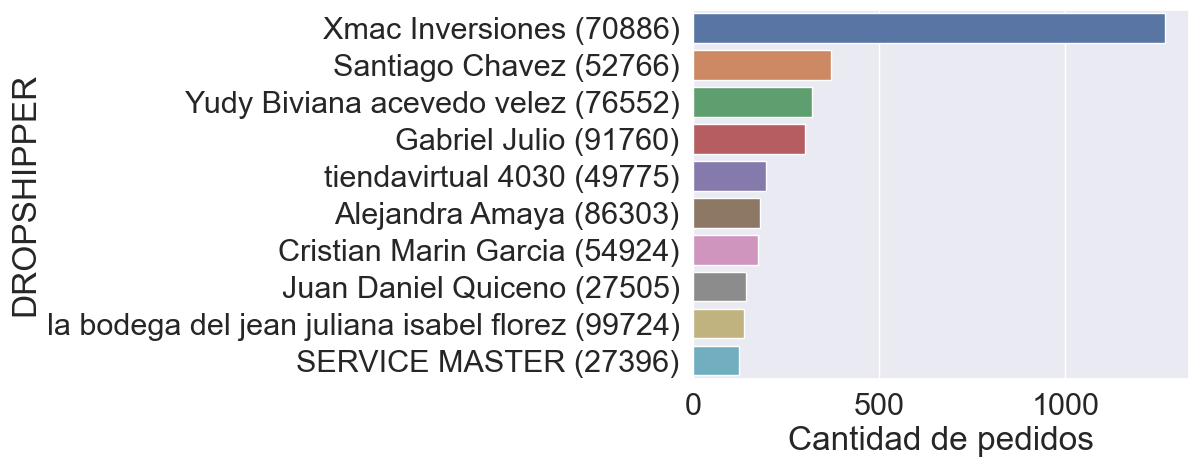

In [79]:
TopDropshippers = adminOrigenLimpio.groupby('DROPSHIPPER')['ESTATUS'].count().reset_index()
TopDropshippers = TopDropshippers[TopDropshippers['DROPSHIPPER'] != 'Comercial Seventy Block (42416)']
TopDropshippers = TopDropshippers.rename(columns= {'ESTATUS' : 'Cantidad de pedidos'})
TopDropshippers = TopDropshippers.nlargest(10, 'Cantidad de pedidos')
display(TopDropshippers)

sns.barplot(y='DROPSHIPPER', x='Cantidad de pedidos', data=TopDropshippers, orient='h')



Eficiencia de transportadoras:

TRANSPORTADORA,COORDINADORA,DOMINA,ENVIA,INTERRAPIDISIMO,SERVIENTREGA
ESTATUS,,,,,
CANCELADO,390,110,749,136,81
DEVOLUCION,467,139,1133,338,117
EN BODEGA TRANSPORTADORA,0,0,0,1,0
EN ESPERA DE RUTA DOMESTICA,0,0,1,0,0
EN PROCESAMIENTO,0,0,0,0,10
EN PROCESO DE INDEMNIZACION,0,0,4,0,0
EN REPARTO,0,0,0,1,0
ENTREGADO,716,308,2376,739,388
GUIA_ANULADA,0,3,2,3,1


TRANSPORTADORA,COORDINADORA,DOMINA,ENVIA,INTERRAPIDISIMO,SERVIENTREGA
ESTATUS,,,,,
CANCELADO,24.0%,18.93%,16.85%,10.61%,13.21%
DEVOLUCION,28.74%,23.92%,25.5%,26.37%,19.09%
EN BODEGA TRANSPORTADORA,0.0%,0.0%,0.0%,0.08%,0.0%
EN ESPERA DE RUTA DOMESTICA,0.0%,0.0%,0.02%,0.0%,0.0%
EN PROCESAMIENTO,0.0%,0.0%,0.0%,0.0%,1.63%
EN PROCESO DE INDEMNIZACION,0.0%,0.0%,0.09%,0.0%,0.0%
EN REPARTO,0.0%,0.0%,0.0%,0.08%,0.0%
ENTREGADO,44.06%,53.01%,53.47%,57.64%,63.3%
GUIA_ANULADA,0.0%,0.52%,0.05%,0.23%,0.16%


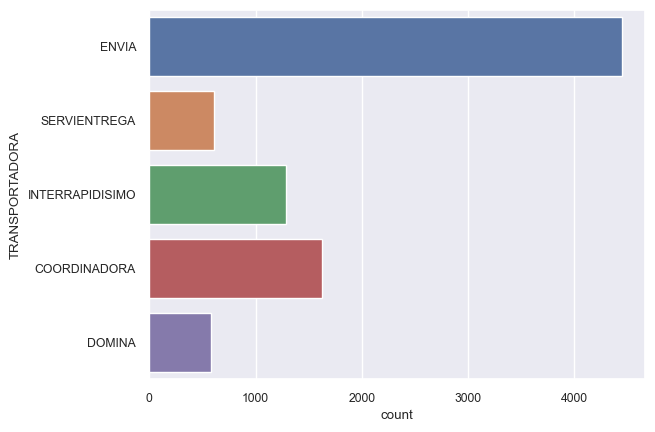

In [81]:
transp_estat = pd.crosstab(adminOrigenLimpio['ESTATUS'], adminOrigenLimpio['TRANSPORTADORA'])
transp_estat_porc = pd.crosstab(adminOrigenLimpio['ESTATUS'], adminOrigenLimpio['TRANSPORTADORA'], normalize='columns') * 100
transp_estat_porc = transp_estat_porc.round(2).astype(str)+'%'
display(transp_estat)
print(' \n ')
display(transp_estat_porc)
sns.set(font_scale=0.8)
ax = sns.countplot(y='TRANSPORTADORA', data=adminOrigenLimpio, orient='h')